In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sim_functions import *

from tqdm import tqdm

from scipy.optimize import curve_fit

Using numpy


In [2]:
nx = 800
ny = 5
steps = 100000
output_stride = 500
molecular_weights = np.array([1,80])
n_species = len(molecular_weights)
multiplier = 50

Bss = multiplier * 1/np.sqrt(1/molecular_weights[0] + 1/molecular_weights[1])
D_lbm = 1/Bss
print('Predict diffusion constant = ', D_lbm)

phi_1 = 0.5
phi_2 = phi_1 * molecular_weights[0]/molecular_weights[1]
phis = np.array([phi_1, phi_2])
print(phis)

Predict diffusion constant =  0.020124611797498106
[0.5     0.00625]


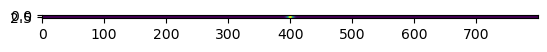

In [3]:
total_pressure = 1
#partial_pressure = xp.array([0.98, 0.02])
#partial_pressure_stripe = xp.array([0.95, 0.05])
partial_pressure_x = np.zeros((n_species, nx))
stripe_width = 5
x_coord = np.arange(nx)
x_gaussian = pow(np.e, -pow((x_coord-nx//2)/stripe_width, 2))

partial_pressure_x[1] = 0.00001 + 0.00001 * x_gaussian
partial_pressure_x[0] = 1-partial_pressure_x[1]

rho_s = np.zeros((n_species, nx,ny))
for s in range(n_species):
    rho_s[s,:,:] = 3* partial_pressure_x[s, :][:, None] * np.ones((nx,ny))

plt.imshow(rho_s[1,:,:].T)

In [4]:
lbm_config = lbm_parameters(
    nx=nx,
    ny=ny,
    steps=steps,
    output_interval=output_stride,
    molecular_weights=xp.array(molecular_weights),
    multiplier=multiplier,
    phis=xp.array(phis),
)

In [5]:
f = xp.zeros((n_species, 9, nx, ny), dtype=DTYPE)
ux_s = xp.zeros((n_species, nx, ny), dtype=DTYPE)
uy_s = xp.zeros((n_species, nx, ny), dtype=DTYPE)
feq = equilibrium(f, xp.array(rho_s), lbm_config, ux_s, uy_s)
f = feq

In [6]:
def diffusion_profile(f):
    phi = 1.0 / xp.array(molecular_weights, dtype=xp.float64)
    rho_s, ux_s, uy_s, rho_mix, p_mix = calculate_moment(f, lbm_config)
    profile = rho_s[1, :, ny//2]
    return profile


In [7]:
def main(f):
    profiles = []
    clip_history = []
    for step in tqdm(range(steps + 1)):
        #if step % output_stride == 0:
            #save_concentration_frames(f, step, lbm_config)
        if step == steps:
            break
        f, clipped = bgk_step(f, lbm_config, lattice_stream)

        clip_history.append(clipped)
        
        profile = diffusion_profile(f)
        profiles.append(profile)
    profiles = xp.array(profiles)
    return to_numpy(profiles)

In [ ]:
profiles = main(f)

  1%|          | 537/100001 [00:02<07:26, 222.60it/s]

In [152]:
np.save("profiles_beta50phi050.npy", profiles)

Text(0, 0.5, 'Concentration')

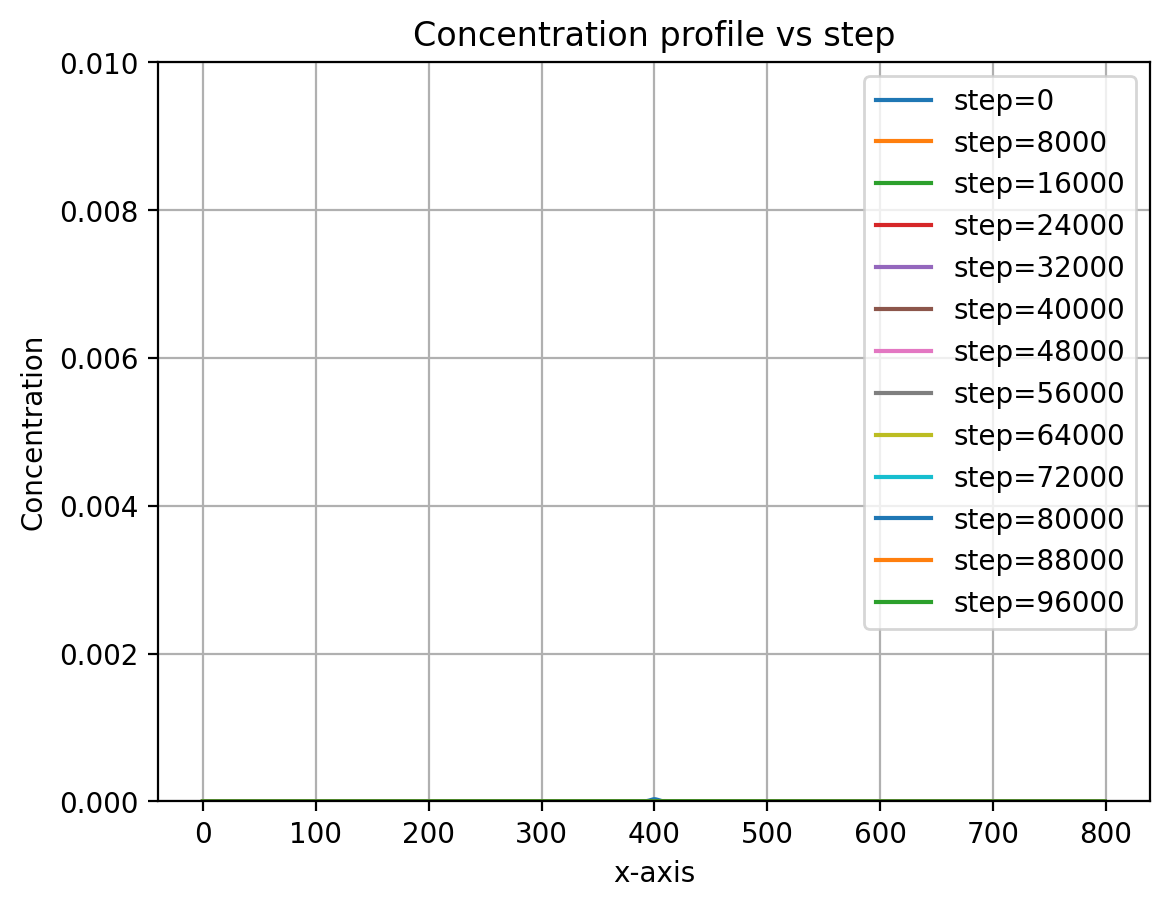

In [153]:
plt.figure(dpi=200)
background = profiles[0,0]
for i in range(steps):
    if i % 8e3 ==1: #8e3
        plt.plot(profiles[i]-background, label = f"step={i-1}")
plt.grid()
plt.ylim([0, 0.01])
plt.legend()

plt.title("Concentration profile vs step")
plt.xlabel("x-axis")
plt.ylabel("Concentration")

In [154]:
def function_diffusion(t, D, C):
    return np.sqrt(2*D*t)

def profile_std(profile, background):
    background = np.mean(profile[0:100])+5e-5
    profile = np.clip(profile - background, 0, np.inf)
    x = np.arange(len(profile))
    total_mass = np.sum(profile)
    x_mean = np.sum(x * profile) / total_mass
    variance = np.sum(profile * (x - x_mean) ** 2) / total_mass
    std = np.sqrt(variance)
    return std

def calc_diff_coef(profiles, start_index):
    stds = []
    for i in range(profiles.shape[0]):
        stds.append(profile_std(profiles[i], background))
    stds = np.array(stds)
    t_axis = np.arange(profiles.shape[0])
    try:
        popt, pcov = curve_fit(function_diffusion, t_axis[start_index:], stds[start_index:])
    except Exception:
        return 0, 0
    return popt, stds

In [155]:
start_index = 1
end_index = -1
popt, stds = calc_diff_coef(profiles[0:end_index], start_index)
D = popt[0]
print(popt)

C:\Users\19162\AppData\Local\Temp\ipykernel_54508\101754334.py:9: RuntimeWarning: invalid value encountered in scalar divide
  x_mean = np.sum(x * profile) / total_mass


TypeError: 'int' object is not subscriptable

Diffusion_constant =  0.015222990443169255


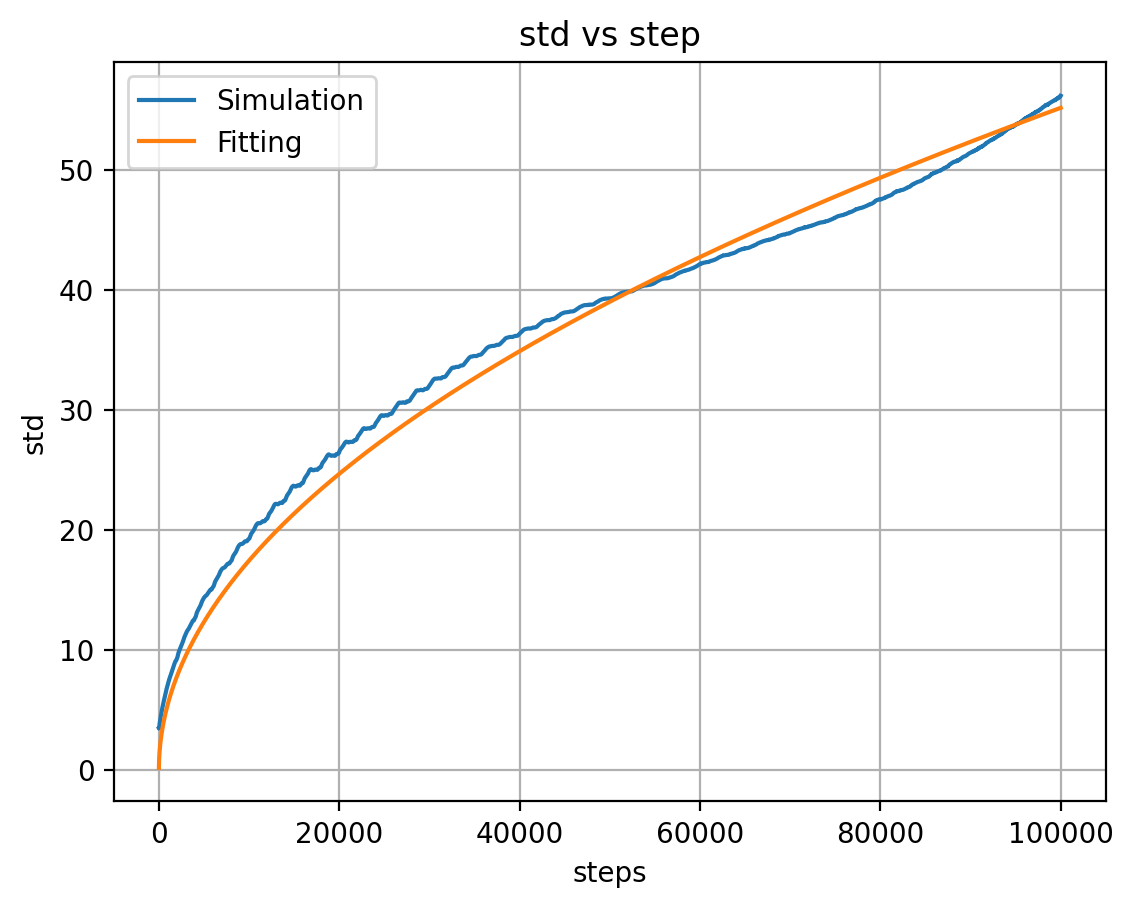

In [137]:
plt.figure(dpi=200)
plt.plot(stds, label = "Simulation")
t_axis = np.arange(steps)
print("Diffusion_constant = ", D)
plt.plot(t_axis[start_index:end_index], function_diffusion(t_axis[start_index:end_index], D, popt[1]), label = "Fitting")

plt.title("std vs step")
plt.xlabel("steps")
plt.ylabel("std")
plt.grid()
plt.legend()

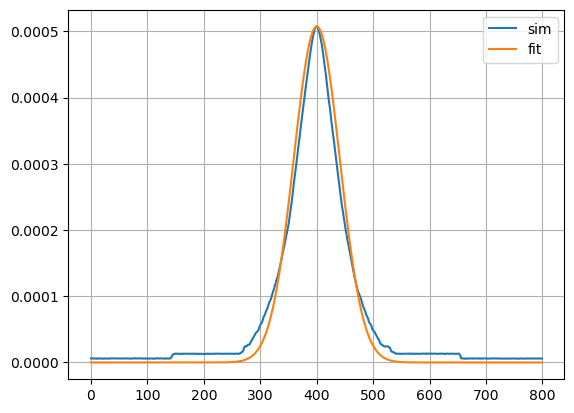

In [90]:

plt.plot(profiles[-1]-background, label = "sim")
plt.grid()

stripe_width = stds[-1]
x_coord = np.arange(nx)
x_gaussian = pow(np.e, -pow((x_coord-nx//2)/stripe_width, 2))
plt.plot(x_gaussian*(np.max(profiles[-1]-background)/np.max(x_gaussian)), label = "fit")
plt.legend()